In [108]:
%matplotlib notebook
#%matplotlib inline
import os
import sys
import math
import h5py
import argparse
import importlib
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import scipy.spatial as spatial
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

from matplotlib import colors as mcolors
from sklearn.cluster import DBSCAN
from matplotlib import animation
import pptk
import numpy as np
import colorsys

In [2]:
from pathlib import Path

my_file = Path("val_zero_1_pred.h5")
if my_file.is_file():
    print("yes")
    
filelist = "val_zero_1_pred.h5"
data = h5py.File(filelist)
list(data)

yes


['confidence', 'data_num', 'indices_split_to_full', 'label_seg']

In [3]:
point_size=0.2
axes_str = ["X", "Y", "Z"]
random_color_box = [ _r for _r in mcolors.CSS4_COLORS]
color_map = ["#CFCDC9", "b","r","g"]
axes_limits = [
   [-100, 80], # X axis range
     [-10, 10], # Y axis range
     [-3, 10]   # Z axis range
 ] 

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):

    
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        plt.plot(vertices[ connection[0], :],vertices[ connection[1], :], c=color, lw=0.5)

        
def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    
    #class_color =  [color_map[int(i)] for i in velo_frame[:, 3]] 
    
  
    class_color =  [random_color_box[int(i)] for i in velo_frame[:, 4]] 
    
    point_sizes =  [ 0.01 if i < 1 else point_size for i in velo_frame[:, 3]] 

    ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_sizes,  c=class_color, cmap='gray')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
   
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

In [4]:
filelist = "val_zero_1_pred.h5"
data = h5py.File(my_file)
data_num = data['data_num'][...].astype(np.float32)

confidence = data['confidence'][...].astype(np.float32)
label_seg = data['label_seg'][...].astype(np.int64)

In [5]:
filelist = "val_zero_1.h5"
data = h5py.File(filelist)
data_train = data['data'][:,:,:].astype(np.float32)

label = data['label'][...].astype(np.int32)
label_train = data['label_seg'][...].astype(np.int64)
data_num_train = data['data_num'][...].astype(np.int32)
print(data_num_train.shape, data_num_train,)
print(np.unique(label, return_counts=True) )


(2004,) [9686 9686 9686 ... 9318    1 9333]
(array([  88,  142,  172,  190,  339,  388,  687,  820,  866,  960,  979,
       1062, 1121, 1124, 1214, 1263, 1445, 1464, 1489, 1551, 1560, 1608,
       1785, 1804, 1845, 1924, 1926, 1933, 1979, 1992, 2099, 2124, 2143,
       2179, 2233, 2239, 2285, 2376, 2400, 2470, 2543, 2724, 2758, 2851,
       2922, 2955, 3020, 3100, 3347, 3350, 3402, 3477, 3484, 3579, 3606,
       3633, 3715, 3717, 3797, 3802, 3815, 3873, 3913, 3962, 4019, 4136,
       4333, 4433, 4544, 4650, 4681, 4690, 4724, 4725, 4775, 4862, 4876,
       4988, 4995, 5005, 5035, 5047, 5122, 5137, 5199, 5204, 5242, 5244,
       5282, 5482, 5523, 5578, 5584, 5609, 5641, 5657, 5695, 5703, 5740,
       5810, 5858, 5867, 5946, 5954, 6026, 6069, 6103, 6106, 6169, 6172,
       6354, 6400, 6402, 6508, 6523, 6569, 6763, 6793, 6800, 6860, 6917,
       7097, 7143, 7216, 7263, 7315, 7460], dtype=int32), array([16, 14, 17, 16, 14, 15, 17, 17, 16, 16, 15, 13, 18, 16, 15, 17, 17,
       15, 17, 17, 

In [6]:
data_frame = []
label_frame = []
confidence_frame = []
indices = np.nonzero(label==5578)
for i in  indices[0]:
    
    data_frame.append(data_train[i,:data_num_train[i]])
    label_frame.append(label_seg[i,:data_num_train[i]])
    confidence_frame.append(confidence[i,:data_num_train[i]])
    
labels = np.concatenate(label_frame)
labels = labels.astype(int)
velo_frame = np.concatenate(data_frame)[:,:3]
confidence_filter= np.concatenate(confidence_frame)
print(velo_frame.shape, confidence_filter.shape)

velo_frame = velo_frame[ np.logical_and(labels >= 1, velo_frame[:,0] >= -100)  ]
confidence_filter = confidence_filter[labels >=1]
labels = labels[labels >=1]
print(velo_frame.shape)

print(np.amax(velo_frame, axis=0))
print(np.amin(velo_frame, axis=0))

#DBSCAN

clustering = DBSCAN(eps=1, min_samples=100).fit(velo_frame)
_inidices = clustering.labels_ > -1
object_ids = clustering.labels_
velo_frame_orig = np.copy(velo_frame)
print(_inidices.shape, np.unique(clustering.labels_[_inidices], return_counts=True))

(138979, 3) (138979,)
(15677, 3)
[64.597  0.498 13.988]
[-1.136 -1.827 -9.495]
(15677,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([4521, 1242, 1525, 5179,  979, 1108,  215,  332,  124]))


In [7]:
data.keys()

<KeysViewHDF5 ['data', 'data_num', 'indices_split_to_full', 'label', 'label_seg']>

In [8]:
id_frame =10
#labels, velo_frame = label_train[id_frame, :data_num_train[id_frame]], data_train[id_frame, :data_num_train[id_frame],:]
labels = np.expand_dims(labels, axis=1)
object_ids = np.expand_dims(object_ids, axis=1)
print(velo_frame.shape, labels.shape)
pointSize = velo_frame.shape[0]
# X, Y, Z, Class, Object_id
velo_frame = np.concatenate( (velo_frame[:,0:1],velo_frame[:,2:3], velo_frame[:,1:2],labels, object_ids) , axis=1)
obj_id = 1

#velo_frame = velo_frame[ np.logical_and(labels >= 1, velo_frame[:,0] >= -100)  ] #load_data#[ load_data[:,3] >= 1 ] #np.logical_and(load_data[:,3] >= 1,  load_data[:,-1]==30) ]
#velo_frame = np.append(velo_frame, [np.amax(velo_frame, axis=0), np.amin(velo_frame, axis=0)], axis=0)

velo_frame = velo_frame[_inidices]

print(velo_frame.shape)



(15677, 3) (15677, 1)
(15225, 5)


In [9]:
np.unique(object_ids)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

<IPython.core.display.Javascript object>


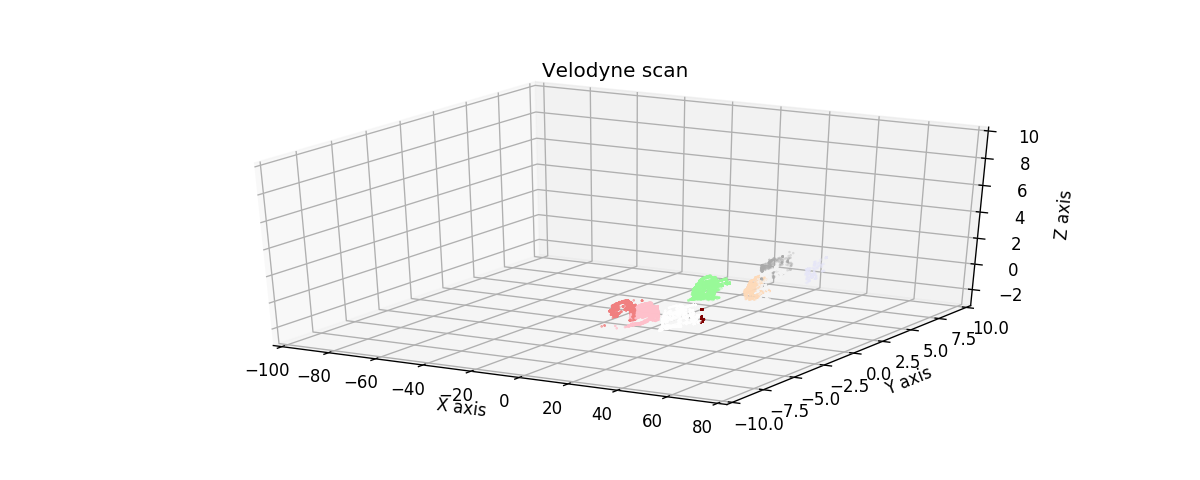

In [46]:
f2 = plt.figure(figsize=(10,4))
axes=[0, 1, 2]
ax2 = f2.add_subplot(111, projection='3d')   
order_ids = np.arange(8)
draw_point_cloud(ax2, 'Velodyne scan', xlim3d=None)
plt.show()

In [11]:
len(velo_frame[:,3] == 2)

15225

In [12]:
data_frame = []
label_frame2 = []
confidence_frame = []
indices = np.nonzero(label==5578)
for i in  indices[0]:
    
    data_frame.append(data_train[i,:data_num_train[i]])
    label_frame2.append(label_train[i,:data_num_train[i]])
    confidence_frame.append(confidence[i,:data_num_train[i]])
    
labels2 = np.concatenate(label_frame2)
labels2 = labels2.astype(int)
velo_frame_act = np.concatenate(data_frame)[:,:3]
confidence_filter= np.concatenate(confidence_frame)
print(velo_frame_act.shape, confidence_filter.shape)

velo_frame2 = velo_frame_act[ np.logical_and(labels2 >= 1, velo_frame_act[:,0] >= -100)  ]
#confidence_filter = confidence_filter[labels >=1]
labels2 = labels2[labels2 >=1]
print(velo_frame2.shape)

print(np.amax(velo_frame2, axis=0))
print(np.amin(velo_frame2, axis=0))

(138979, 3) (138979,)
(10500, 3)
[30.008 -0.113  4.734]
[ 0.416 -1.738 -3.56 ]


In [13]:
velo_frame_act

array([[  1.165,  -1.858,  13.366],
       [ 10.547,   0.688,  -9.434],
       [  5.591,   0.465,  -9.809],
       ...,
       [  5.249,   0.542, -10.946],
       [ -3.152,  -0.853,   3.04 ],
       [  4.182,  -1.747,   4.688]], dtype=float32)

In [14]:
velo_frame = velo_frame[ np.logical_and(labels >= 1, velo_frame[:,0] >= -100)  ]
confidence_filter = confidence_filter[labels >=1]
labels = labels[labels >=1]
print(velo_frame.shape)

print(np.amax(velo_frame, axis=0))
print(np.amin(velo_frame, axis=0))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15225 but corresponding boolean dimension is 15677

In [15]:
confidence_filter

array([0.9999826 , 0.99999666, 0.9999887 , ..., 0.99975747, 0.9999385 ,
       0.9798533 ], dtype=float32)

In [16]:
def get_all_points(velo_frame, object_ids, obj_num):
    # As we know the id of class, compare with object_id vector and store boolean array
    # COmpare the boolean array with the velod_frame to get all points 
    # return the array
    bool_arr = object_ids == obj_num
    obj_arr = velo_frame[bool_arr]
    class_id = max(np.unique(velo_frame[:3]))
    return obj_arr, class_id

def find_the_corners(class_array):
    # Find the max and min of each columnn in axis 0 
    # Get distance from max and min
    # do l/2 to all 3 distances and create array of corners
    xmax = max(class_array[:,0])
    xmin = min(class_array[:,0])
    ymax = max(class_array[:,1])
    ymin = min(class_array[:,1])
    zmax = max(class_array[:,2])
    zmin = min(class_array[:,2])
    crners = np.array([
            [xmin, xmin, xmax, xmax, xmin, xmin, xmax, xmax],
            [ymax, ymin, ymin, ymax, ymax, ymin, ymin, ymax],
            [0.0, 0.0, 0.0, 0.0, zmin, zmin, zmin, zmin]
        ])
    
    return crners

def plot_box(pyplot_axis, corners, class_id, color_id):
    # plot the corners
    axes = [0, 1, 2]
    corners = corners[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*corners[:, connection], c="black", lw=0.5)
    

In [24]:
f2 = plt.figure(figsize=(10,4))
axes=[0, 1, 2]
ax2 = f2.add_subplot(111, projection='3d')   
order_ids = np.arange(8)
draw_point_cloud(ax2, 'Velodyne scan', xlim3d=None)
random_color_box = [ _r for _r in mcolors.CSS4_COLORS]
colors = {}
object_ids2 = object_ids[object_ids > -1]
for i in range(8):
    colors[i] = random_color_box[10*i]
# colors = {0:random_color_box[10], 1:, 2:, 3:, 4:, 5:, 6:, 7:, 8: }
color_class_dict = {0:"blue", 1:"green", 2:"black", 3:"pink"}
object_array = []
corner_array = []
for each_class in np.arange(len(np.unique(object_ids2))-1):
    obj_array, color_id = get_all_points(velo_frame, object_ids2, each_class)
    corners = find_the_corners(obj_array)
    plot_box(ax2, corners, each_class,color_id)
    object_array.append(obj_array)
    corner_array.append(np.transpose(corners))
f2.canvas.draw()
#plt.pause(20)

In [32]:
all_box_array = np.asarray(corner_array)

In [20]:
def draw_lidar_simple(pc, color=None):
    ''' Draw lidar points. simplest set up. '''
    fig = mlab.figure(figure=None, bgcolor=(0,0,0), fgcolor=None, engine=None, size=(1600, 1000))
    if color is None: color = pc[:,2]
    #draw points
    mlab.points3d(pc[:,0], pc[:,1], pc[:,2], color, color=None, mode='point', colormap = 'gnuplot', scale_factor=1, figure=fig)
    #draw origin
    mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2)
    #draw axis
    axes=np.array([
        [2.,0.,0.,0.],
        [0.,2.,0.,0.],
        [0.,0.,2.,0.],
    ],dtype=np.float64)
    mlab.plot3d([0, axes[0,0]], [0, axes[0,1]], [0, axes[0,2]], color=(1,0,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[1,0]], [0, axes[1,1]], [0, axes[1,2]], color=(0,1,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[2,0]], [0, axes[2,1]], [0, axes[2,2]], color=(0,0,1), tube_radius=None, figure=fig)
    mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=62.0, figure=fig)
    return fig
def draw_gt_boxes3d(gt_boxes3d, fig, color=(1,1,1), line_width=1, draw_text=True, text_scale=(1,1,1), color_list=None):
    ''' Draw 3D bounding boxes
    Args:
        gt_boxes3d: numpy array (n,8,3) for XYZs of the box corners
        fig: mayavi figure handler
        color: RGB value tuple in range (0,1), box line color
        line_width: box line width
        draw_text: boolean, if true, write box indices beside boxes
        text_scale: three number tuple
        color_list: a list of RGB tuple, if not None, overwrite color.
    Returns:
        fig: updated fig
    ''' 
    num = len(gt_boxes3d)
    for n in range(num):
        b = gt_boxes3d[n]
        if color_list is not None:
            color = color_list[n] 
        if draw_text: mlab.text3d(b[4,0], b[4,1], b[4,2], '%d'%n, scale=text_scale, color=color, figure=fig)
        for k in range(0,4):
            #http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
            i,j=k,(k+1)%4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,
                                                     1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)

            i,j=k+4,(k+1)%4 + 4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)

            i,j=k,k+4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
    mlab.show()
    #mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=62.0, figure=fig)

In [21]:
matplotlib.use('tkAgg')

In [31]:
import mayavi.mlab as mlab
fig = draw_lidar_simple(object_array[0])
draw_gt_boxes3d(all_box_array,fig)

In [38]:
#import bmesh
import math
import random
import time
#from mathutils import Vector, Matrix
import numpy as np
from scipy.spatial import ConvexHull


<IPython.core.display.Javascript object>


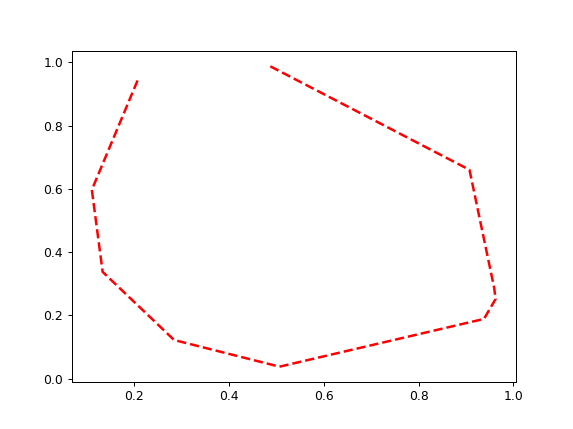

In [109]:
points = np.random.rand(30, 2)
hull = ConvexHull(points)
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.show()

<IPython.core.display.Javascript object>


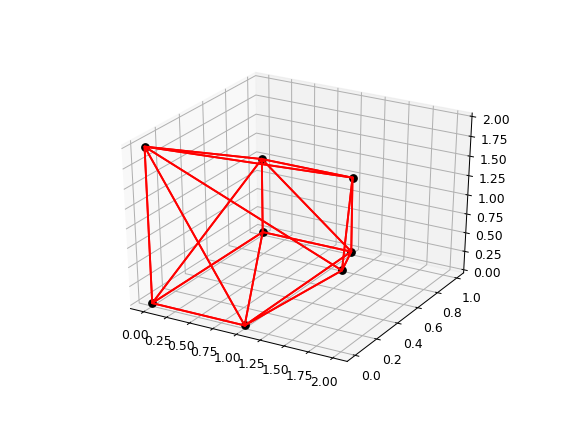

In [110]:
pts = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                [0, 0, 2], [2, 0, 1], [1, 1, 1], [0, 1, 1], ])

hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

for s in hull.simplices:
    s = np.append(s, s[0]) 
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

<IPython.core.display.Javascript object>


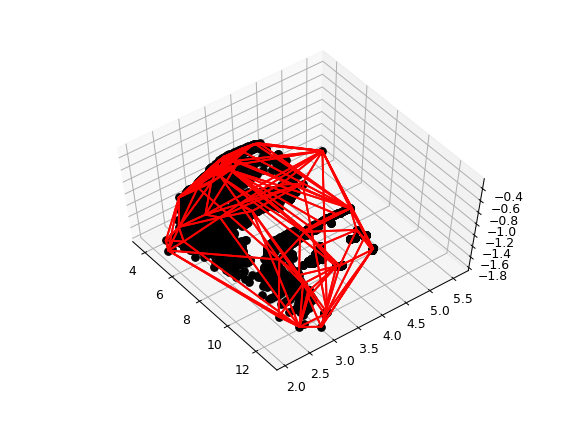

In [111]:
pts = np.array(object_array[0][:,0:3])

hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

for s in hull.simplices:
    s = np.append(s, s[0])
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

<IPython.core.display.Javascript object>


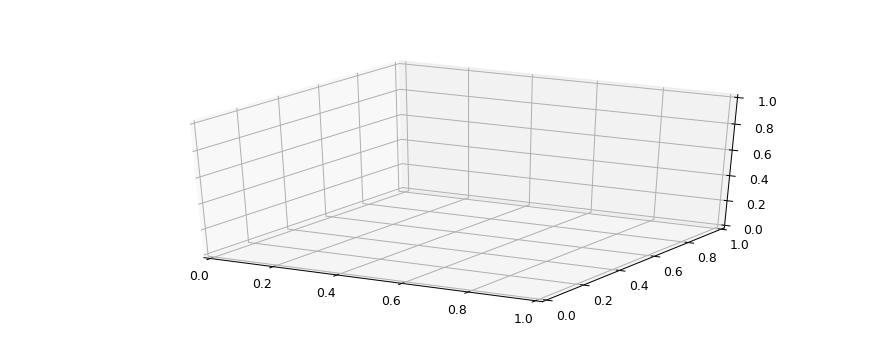

('Hull area: ', 18.788139095249253)
[11.28299999 12.47200012  4.00699997 11.28299999]
<built-in function zeros>


IndexError: tuple index out of range

In [123]:
#get convex hull
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(111, projection='3d')   

# get svd
vert_data = object_array[0][:,[0,1,2]]  #ToDo...world coords better?
v0 = np.array(vert_data, dtype=np.float64, copy=True)
ndims = v0.shape


hull = ConvexHull(vert_data)
# **In 2D "volume" is is area, "area" is perimeter
print(('Hull area: ', hull.volume))
simarr = np.zeros 
for s in hull.simplices:
    s = np.append(s, s[0])
    #ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")
    print(pts[s, 0])
    break
    simarr.append([pts[s, 0], pts[s, 1], pts[s, 2]])
    #print(hull.vertices)
    
for vert in hull.vertices:
#plt.plot(x,y,z)
#f.show()
#plt.show()
v0 = np.asarray(simarr)
print(v0)
ndims = v0.shape[0]
print(ndims)
nd.seeyou

#move data to origin
t0 = -np.mean(v0, axis=1)
M0 = np.identity(ndims+1)
M0[:ndims, ndims] = t0
v0 += t0.reshape(ndims, 1)

U, s, V = np.linalg.svd(v0, full_matrices=True)

#make a rotation matrix from eigenvectors (easy)
rmx = Matrix.Identity(4)
rmx[0][0], rmx[0][1], rmx[0][2] = V[0][0], V[0][1], V[0][2]
rmx[1][0], rmx[1][1], rmx[1][2] = V[1][0], V[1][1], V[1][2]
rmx[2][0], rmx[2][1], rmx[2][2] = V[2][0], V[2][1], V[2][2]


min_box = bbox_orient(vert_data, rmx)
min_vol = bbox_vol(min_box)
min_angle = 0
min_mx = rmx

#these are our PCA directions
X = Vector(( V[0][0], V[0][1], V[0][2]))
Y = Vector(( V[1][0], V[1][1], V[1][2]))
Z = Vector(( V[2][0], V[2][1], V[2][2]))

method = 'pca_y'
for n in range(0, 2 * spin_res):
    angle = math.pi * n/(2 * spin_res)

    rmx = Matrix.Identity(4)

    if method == 'pca_x':  #keep x axis and rotate around it
        rmx[0][0], rmx[0][1], rmx[0][2] = X[0], X[1], X[2]

        y = math.cos(angle) * Y + math.sin(angle) * Z
        y.normalize()
        rmx[1][0], rmx[1][1], rmx[1][2] = y[0], y[1], y[2]

        z = -math.sin(angle) * Y + math.cos(angle) * Z
        z.normalize()
        rmx[2][0], rmx[2][1], rmx[2][2] = z[0], z[1], z[2]

    elif method == 'pca_y': #keep y axis and rotate around it
        x = math.cos(angle) * X - math.sin(angle) * Z
        x.normalize()
        rmx[0][0], rmx[0][1], rmx[0][2] = x[0], x[1], x[2]
        #keep y
        rmx[1][0], rmx[1][1], rmx[1][2] = Y[0], Y[1], Y[2]

        z = math.sin(angle) * X + math.cos(angle) * Z
        z.normalize()
        rmx[2][0], rmx[2][1], rmx[2][2] = z[0], z[1], z[2]

    else:
        x = math.cos(angle) * X + math.sin(angle) * Y
        x.normalize()
        rmx[0][0], rmx[0][1], rmx[0][2] = x[0], x[1], x[2]

        y = -math.sin(angle) * X + math.cos(angle) * Y
        y.normalize()
        rmx[1][0], rmx[1][1], rmx[1][2] = y[0], y[1], y[2]

        #Keep Z
        rmx[2][0], rmx[2][1], rmx[2][2] = Z[0], Z[1], Z[2]

    box = bbox_orient(vert_data, rmx)
    test_V = bbox_vol(box)
    if test_V < min_vol:
        min_angle = angle
        min_box = box
        min_mx = rmx
        min_vol = test_V

    

In [ ]:
def bbox_orient(bme_verts, mx):
    '''
    takes a lsit of BMverts ora  list of vectors
    '''

    verts = [mx * v for v in bme_verts]
        
    xs = [v[0] for v in verts]
    ys = [v[1] for v in verts]
    zs = [v[2] for v in verts]
    
    return (min(xs), max(xs), min(ys), max(ys), min(zs), max(zs))

def bbox_vol(box):
    
    V = (box[1]-box[0]) * (box[3]-box[2]) * (box[5]-box[4])
    
    return V

def box_cords(box):
    '''
    returns vertices in same configuration as default cube in blender
    easy to asign v.co of a cube primitive
    '''
    cords = [Vector((box[0],box[2],box[4])),
             Vector((box[0],box[2],box[5])),
             Vector((box[0],box[3],box[4])),
             Vector((box[0],box[3],box[5])),
             Vector((box[1],box[2],box[4])),
             Vector((box[1],box[2],box[5])),
             Vector((box[1],box[3],box[4])),
             Vector((box[1],box[3],box[5])),
             ]
    
return cords

In [ ]:
def normalizeAngle(angle):
    result = angle % (2*Pi)
    if result < -1*pi:
        result += 2*pi
    elif result >= pi:
        result-= 2*pi
    return result

def computeAlpha(corners):
    connections = [
        [0, 2], [1,3]
    ]
    center  = (corners[:, 0] + corners[:, 2])/2
    angle_x = math.tan2(corners[1, 0] - corners[1, 1])/(corners[0, 0] - corners[0, 1])
    

In [ ]:
for o = 1:numel(objects)

  % set label, truncation, occlusion
  if isfield(objects(o),'type'),         fprintf(fid,'%s ',objects(o).type);
  else                                   error('ERROR: type not specified!'), end;
  if isfield(objects(o),'truncation'),   fprintf(fid,'%.2f ',objects(o).truncation);
  else                                   fprintf(fid,'-1 '); end; % default
  if isfield(objects(o),'occlusion'),    fprintf(fid,'%.d ',objects(o).occlusion);
  else                                   fprintf(fid,'-1 '); end; % default
  if isfield(objects(o),'alpha'),        fprintf(fid,'%.2f ',wrapToPi(objects(o).alpha));
  else                                   fprintf(fid,'-10 '); end; % default

  % set 2D bounding box in 0-based C++ coordinates
  if isfield(objects(o),'x1'),           fprintf(fid,'%.2f ',objects(o).x1);
  else                                   error('ERROR: x1 not specified!'); end;
  if isfield(objects(o),'y1'),           fprintf(fid,'%.2f ',objects(o).y1);
  else                                   error('ERROR: y1 not specified!'); end;
  if isfield(objects(o),'x2'),           fprintf(fid,'%.2f ',objects(o).x2);
  else                                   error('ERROR: x2 not specified!'); end;
  if isfield(objects(o),'y2'),           fprintf(fid,'%.2f ',objects(o).y2);
  else                                   error('ERROR: y2 not specified!'); end;

  % set 3D bounding box
  if isfield(objects(o),'h'),            fprintf(fid,'%.2f ',objects(o).h);
  else                                   fprintf(fid,'-1 '); end; % default
  if isfield(objects(o),'w'),            fprintf(fid,'%.2f ',objects(o).w);
  else                                   fprintf(fid,'-1 '); end; % default
  if isfield(objects(o),'l'),            fprintf(fid,'%.2f ',objects(o).l);
  else                                   fprintf(fid,'-1 '); end; % default
  if isfield(objects(o),'t'),            fprintf(fid,'%.2f %.2f %.2f ',objects(o).t);
  else                                   fprintf(fid,'-1000 -1000 -1000 '); end; % default
  if isfield(objects(o),'ry'),           fprintf(fid,'%.2f ',wrapToPi(objects(o).ry));
  else                                   fprintf(fid,'-10 '); end; % default

  % set score
  if isfield(objects(o),'score'),        fprintf(fid,'%.2f ',objects(o).score);
  else                                   error('ERROR: score not specified!'); end;


In [ ]:
# actual
veloframe_new = velo_frame2[:,[2,0,1]]

x = veloframe_new[:, :3]
v = pptk.viewer(x)
v.set(point_size=0.005)

In [ ]:
#prediction
veloframe_new2 = velo_frame[:,[0,1,2]]
x = veloframe_new2[:, :3]
v = pptk.viewer(x)
v.set(point_size=0.005)

In [ ]:
len(x)

In [ ]:
#Shaded by color
rgblist = []
for i in range(len(x)):
    rgb = colorsys.hsv_to_rgb(confidence_filter[i] / 3., 1.0, 1.0)
    rgblist.append([round(255*x) for x in rgb])
    #print(i, [round(255*x) for x in rgb])

In [ ]:


#random_color_box = [ _r for _r in mcolors.CSS4_COLORS]
#class_color =  [random_color_box[int(i)] for i in velo_frame[:, 4]] 
#rgb = pptk.rand(velo_frame.shape[0], 3)
z = pptk.viewer(x, rgblist)
z.set(point_size=0.005)

In [ ]:
import mayavi.mlab as mlab

black = (0,0,0)
white = (1,1,1)
mlab.figure(bgcolor=white)
mlab.plot3d([0, 1000], [0, 0], [0, 0], color=black, tube_radius=10.)
mlab.plot3d([0, 0], [0, 1500], [0, 0], color=black, tube_radius=10.)
mlab.plot3d([0, 0], [0, 0], [0, 1500], color=black, tube_radius=10.)

#### Checking th orientation of bounding boxes using fnet

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial import ConvexHull

import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import kitti_object
import kitti_util
import prepare_data
import box_util
import provider